In [1]:
import time
import os
import copy

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, transforms
import numpy as npy
# Pennylane
import pennylane as qml
from pennylane import numpy as np

torch.manual_seed(42)
np.random.seed(42)

# Plotting
import matplotlib.pyplot as plt

n_qubits = 4                
step = 0.0004               
batch_size = 4              
num_epochs = 3              
q_depth = 6                 
gamma_lr_scheduler = 0.1    
q_delta = 0.01              
start_time = time.time() 


dev = qml.device("default.qubit", wires=n_qubits)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.autograd import Function
from torchvision import datasets, transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F


In [3]:

class Circuit2(object):
    def __init__(self):
        self.dev_qubit = qml.device('default.qubit', wires=1,shots=100)
    def quantumcirc(self, x):
        @qml.qnode(self.dev_qubit)   
        def _quantumcirc(x):
            qml.Hadamard(wires=(0))
            qml.RY(x, wires=(0))
            qml.PauliZ(0)
            return qml.counts()
        return _quantumcirc(x)
    
    def exp_val(self,thetas):
        shots=100
        result = Circuit2().quantumcirc(thetas[0])
        counts = np.array(list(result.values()))
        states = np.array(list(result.keys())).astype(float)   
        probabilities = counts / shots
        expectation = np.sum(states * probabilities)
        return np.array([expectation])
 


In [4]:
class HybridFunction(Function):
    """ Hybrid quantum - classical function definition """
    
    @staticmethod
    def forward(ctx, input, quantum_circuit, shift):
        """ Forward pass computation """
        ctx.shift = shift
        ctx.quantum_circuit = quantum_circuit

        expectation_z = ctx.quantum_circuit.exp_val(input[0].tolist())
        result = torch.tensor([expectation_z])
        ctx.save_for_backward(input, result)

        return result
        
    @staticmethod
    def backward(ctx, grad_output):
        """ Backward pass computation """
        
        
        input, expectation_z = ctx.saved_tensors
        input_list = np.array(input.tolist())
        shift_right = input_list + np.ones(input_list.shape) * ctx.shift
        shift_left = input_list - np.ones(input_list.shape) * ctx.shift
        gradients = []
        for i in range(len(input_list)):
            expectation_right = ctx.quantum_circuit.exp_val(shift_right[i])
            expectation_left  = ctx.quantum_circuit.exp_val(shift_left[i])
            
            gradient = torch.tensor([expectation_right]) - torch.tensor([expectation_left])
            gradients.append(gradient)
        gradients = np.array([gradients]).T
        return torch.tensor([gradients]).float() * grad_output.float(), None, None

class Hybrid(nn.Module):
    """ Hybrid quantum - classical layer definition """
    
    def __init__(self, shift):
        super(Hybrid, self).__init__()
        
        self.quantum_circuit = Circuit2()
        self.shift = shift
        
        
    def forward(self, input):
        return HybridFunction.apply(input, self.quantum_circuit, self.shift)


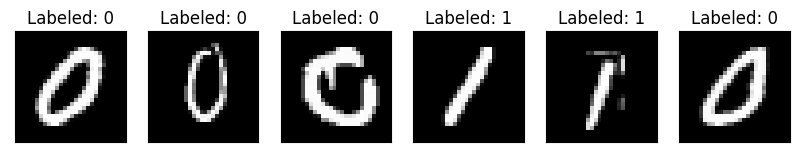

In [5]:
n_samples = 100

X_train = datasets.MNIST(root='./data', train=True, download=True,
                         transform=transforms.Compose([transforms.ToTensor()]))
idx = np.append(np.where(X_train.targets == 0)[0][:n_samples], 
                np.where(X_train.targets == 1)[0][:n_samples])

X_train.data = X_train.data[idx]
X_train.targets = X_train.targets[idx]

train_loader = torch.utils.data.DataLoader(X_train, batch_size=1, shuffle=True)

n_samples_show = 6

data_iter = iter(train_loader)
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 3))

while n_samples_show > 0:
    images, targets = data_iter.__next__()

    axes[n_samples_show - 1].imshow(images[0].numpy().squeeze(), cmap='gray')
    axes[n_samples_show - 1].set_xticks([])
    axes[n_samples_show - 1].set_yticks([])
    axes[n_samples_show - 1].set_title("Labeled: {}".format(targets.item()))
    
    n_samples_show -= 1

In [6]:
n_samples = 50

X_test = datasets.MNIST(root='./data', train=False, download=True,
                        transform=transforms.Compose([transforms.ToTensor()]))

idx = np.append(np.where(X_test.targets == 0)[0][:n_samples], 
                np.where(X_test.targets == 1)[0][:n_samples])

X_test.data = X_test.data[idx]
X_test.targets = X_test.targets[idx]

test_loader = torch.utils.data.DataLoader(X_test, batch_size=1, shuffle=True)

In [7]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.dropout = nn.Dropout2d()
        self.fc1 = nn.Linear(256, 64)
        self.fc2 = nn.Linear(64, 1)
        self.hybrid = Hybrid( np.pi / 2)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)
        x = x.view(1, -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.hybrid(x)
        return torch.cat((x, 1 - x), -1)


In [8]:
model = Net()
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.NLLLoss()

epochs = 20
loss_list = []

model.train()
for epoch in range(epochs):
    total_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        loss = loss_func(output, target)
        # Backward pass
        loss.backward()
        # Optimize the weights
        optimizer.step()
        
        total_loss.append(loss.item())
    loss_list.append(sum(total_loss)/len(total_loss))
    print('Training [{:.0f}%]\tLoss: {:.4f}'.format(
        100. * (epoch + 1) / epochs, loss_list[-1]))

C:\Users\kamja\Python\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:204.)
  # This is added back by InteractiveShellApp.init_path()
C:\Users\kamja\Python\lib\site-packages\ipykernel_launcher.py:32: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.


Training [5%]	Loss: -0.7731
Training [10%]	Loss: -0.9097
Training [15%]	Loss: -0.9303
Training [20%]	Loss: -0.9413
Training [25%]	Loss: -0.9416
Training [30%]	Loss: -0.9578
Training [35%]	Loss: -0.9621
Training [40%]	Loss: -0.9696
Training [45%]	Loss: -0.9711
Training [50%]	Loss: -0.9682
Training [55%]	Loss: -0.9757
Training [60%]	Loss: -0.9785
Training [65%]	Loss: -0.9822
Training [70%]	Loss: -0.9864
Training [75%]	Loss: -0.9857
Training [80%]	Loss: -0.9891
Training [85%]	Loss: -0.9882
Training [90%]	Loss: -0.9886
Training [95%]	Loss: -0.9934
Training [100%]	Loss: -0.9936


Text(0, 0.5, 'Neg Log Likelihood Loss')

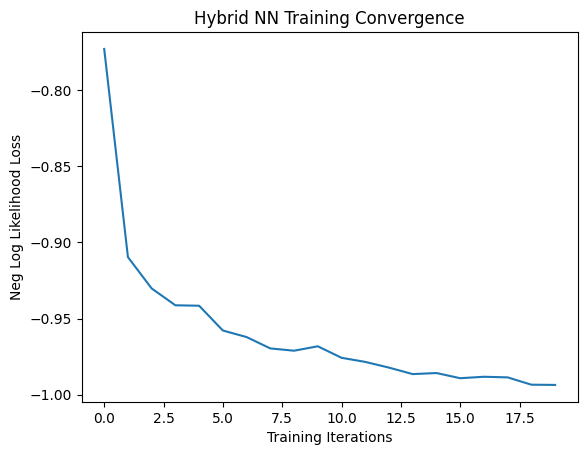

In [9]:
plt.plot(loss_list)
plt.title('Hybrid NN Training Convergence')
plt.xlabel('Training Iterations')
plt.ylabel('Neg Log Likelihood Loss')

In [10]:
model.eval()
with torch.no_grad():
    
    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        output = model(data)
        
        pred = output.argmax(dim=1, keepdim=True) 
        correct += pred.eq(target.view_as(pred)).sum().item()
        
        loss = loss_func(output, target)
        total_loss.append(loss.item())
        
    print('Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%'.format(
        sum(total_loss) / len(total_loss),
        correct / len(test_loader) * 100)
        )


Performance on test data:
	Loss: -0.9909
	Accuracy: 100.0%


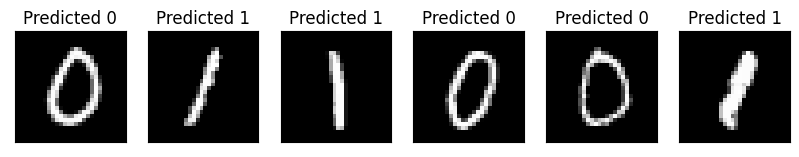

In [11]:
n_samples_show = 6
count = 0
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 3))

model.eval()
with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        if count == n_samples_show:
            break
        output = model(data)
        
        pred = output.argmax(dim=1, keepdim=True) 

        axes[count].imshow(data[0].numpy().squeeze(), cmap='gray')

        axes[count].set_xticks([])
        axes[count].set_yticks([])
        axes[count].set_title('Predicted {}'.format(pred.item()))
        
        count += 1
